In [179]:
#Download required ntlk packages and lib
import nltk
nltk.download("vader_lexicon")
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vlad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vlad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [180]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from collections import Counter
import re
import math
import html
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

import pymongo
from pymongo import MongoClient
import pprint
%matplotlib inline

In [181]:
#Sentences to try with vader
sentences = ["VADER is smart, handsome, and funny.",
             "Data Scientists are sexy!",
             "The room was dirty and small",
             "They had excellent facilities!",
             "This hotel is the worst hotel in the city"]

In [182]:

#Instantiate an instance to access SentimentIntensityAnalyzer class
sid = SentimentIntensityAnalyzer()

In [183]:
#Vader output
for sentence in sentences:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
         print('{0}: {1}, '.format(k, ss[k]), end='')
    print('\n')

VADER is smart, handsome, and funny.
compound: 0.8316, neg: 0.0, neu: 0.254, pos: 0.746, 

Data Scientists are sexy!
compound: 0.5707, neg: 0.0, neu: 0.448, pos: 0.552, 

The room was dirty and small
compound: -0.4404, neg: 0.367, neu: 0.633, pos: 0.0, 

They had excellent facilities!
compound: 0.6114, neg: 0.0, neu: 0.429, pos: 0.571, 

This hotel is the worst hotel in the city
compound: -0.6249, neg: 0.339, neu: 0.661, pos: 0.0, 



In [185]:
# Read in from pandas
hotelDf = pd.read_csv('JBNYC11.csv')
# hotelDf.columns=['id','filePath','hotelName','review','ratingScore','groundTruth']
hotelDf.columns=['filePath','hotelName','review','ratingScore','groundTruth']
hotelDf.head()

,filePath,hotelName,review,ratingScore,groundTruth
0,OUT/com/60763/10036825/420085463.html,Interfaith Retreats,"""I normally write if I really like a place and...",2,negative
1,OUT/com/60763/10036825/420586978.html,Interfaith Retreats,"""I was looking for an inexpensive place to sta...",3,negative
2,OUT/com/60763/10036825/442576047.html,Interfaith Retreats,"""I stayed here for 2 nights and I paid for $15...",3,negative
3,OUT/com/60763/10036825/446101397.html,Interfaith Retreats,"""I loved this place. It is clean, quiet and co...",5,positive
4,OUT/com/60763/10036825/607185918.html,Interfaith Retreats,"""I twice tried booking a room here, several we...",1,negative


In [186]:
df_filter = pd.read_csv('JBNYC11.csv')
# hotelDf.columns=['id','filePath','hotelName','review','ratingScore','groundTruth']
df_filter.columns=['filePath','hotelName','review','ratingScore','groundTruth']
df_filter.head()

,filePath,hotelName,review,ratingScore,groundTruth
0,OUT/com/60763/10036825/420085463.html,Interfaith Retreats,"""I normally write if I really like a place and...",2,negative
1,OUT/com/60763/10036825/420586978.html,Interfaith Retreats,"""I was looking for an inexpensive place to sta...",3,negative
2,OUT/com/60763/10036825/442576047.html,Interfaith Retreats,"""I stayed here for 2 nights and I paid for $15...",3,negative
3,OUT/com/60763/10036825/446101397.html,Interfaith Retreats,"""I loved this place. It is clean, quiet and co...",5,positive
4,OUT/com/60763/10036825/607185918.html,Interfaith Retreats,"""I twice tried booking a room here, several we...",1,negative


In [187]:
df_filter = df_filter.groupby(['hotelName'])['groundTruth'].agg(['count'])
df_filter

,count
hotelName,
11 Howard,341
AKA Wall Street,75
Arlo NoMad,203
Carnegie Hotel,86
Chez Michelle,11
EVEN Hotel New York - Midtown East,509
Fairfield Inn &amp; Suites New York Manhattan/Central Park,149
Greenwich Hotel,267
Hyatt House New York/Chelsea,289


In [188]:
df_filter = df_filter.reset_index()

In [189]:
df_filter = df_filter.loc[df_filter['count']>50]
df_filter

,hotelName,count
0,11 Howard,341
1,AKA Wall Street,75
2,Arlo NoMad,203
3,Carnegie Hotel,86
5,EVEN Hotel New York - Midtown East,509
6,Fairfield Inn &amp; Suites New York Manhattan/...,149
7,Greenwich Hotel,267
8,Hyatt House New York/Chelsea,289
11,The Hotel 91,281
12,The Ridge Hotel,222


In [190]:
df_filter['hotelName']

0                                             11 Howard
1                                       AKA Wall Street
2                                            Arlo NoMad
3                                        Carnegie Hotel
5                    EVEN Hotel New York - Midtown East
6     Fairfield Inn &amp; Suites New York Manhattan/...
7                                       Greenwich Hotel
8                          Hyatt House New York/Chelsea
11                                         The Hotel 91
12                                      The Ridge Hotel
Name: hotelName, dtype: object

In [191]:
hotelDf = pd.merge(hotelDf, df_filter, how='inner', indicator=True)
hotelDf

,filePath,hotelName,review,ratingScore,groundTruth,count,_merge
0,OUT/com/60763/10039979/393279496.html,AKA Wall Street,"""When we arrive at the hotel our reception was...",4,positive,75,both
1,OUT/com/60763/10039979/393723666.html,AKA Wall Street,"""Visited NY July 16th to celebrate my best fri...",4,positive,75,both
2,OUT/com/60763/10039979/410243003.html,AKA Wall Street,"""From the booking of the reservation and last ...",5,positive,75,both
3,OUT/com/60763/10039979/414744681.html,AKA Wall Street,"""New property in an ideal location, less than ...",5,positive,75,both
4,OUT/com/60763/10039979/425779778.html,AKA Wall Street,"""Stayed for 10 days in a 2 bedroom apartment. ...",5,positive,75,both
5,OUT/com/60763/10039979/433789915.html,AKA Wall Street,"""AKA Wall Street is a newly opened place in a ...",5,positive,75,both
6,OUT/com/60763/10039979/434069006.html,AKA Wall Street,"""the people and staff over there were good\\nA...",5,positive,75,both
7,OUT/com/60763/10039979/434851198.html,AKA Wall Street,"""After arriving from a long-haul flight from E...",1,negative,75,both
8,OUT/com/60763/10039979/435343633.html,AKA Wall Street,"""Upon landing in NYC, I received an email from...",5,positive,75,both
9,OUT/com/60763/10039979/436484473.html,AKA Wall Street,"""Loved AKA Walk Street. The area is great wi...",5,positive,75,both


In [192]:
hotelDf['hotelName'].unique()

array(['AKA Wall Street', '11 Howard', 'The Ridge Hotel',
       'EVEN Hotel New York - Midtown East', 'Greenwich Hotel',
       'Fairfield Inn &amp; Suites New York Manhattan/Central Park',
       'Hyatt House New York/Chelsea', 'The Hotel 91', 'Carnegie Hotel',
       'Arlo NoMad'], dtype=object)

In [193]:
import re
df2=hotelDf['hotelName'].unique()

hotelStr=[]
for i in df2:
    hotelStr.append(re.sub(r'[.!,;?]', ' ', i).split())
print(hotelStr)

[['AKA', 'Wall', 'Street'], ['11', 'Howard'], ['The', 'Ridge', 'Hotel'], ['EVEN', 'Hotel', 'New', 'York', '-', 'Midtown', 'East'], ['Greenwich', 'Hotel'], ['Fairfield', 'Inn', '&amp', 'Suites', 'New', 'York', 'Manhattan/Central', 'Park'], ['Hyatt', 'House', 'New', 'York/Chelsea'], ['The', 'Hotel', '91'], ['Carnegie', 'Hotel'], ['Arlo', 'NoMad']]


In [194]:
flat_list = [item for sublist in hotelStr for item in sublist]
flat_list

['AKA',
 'Wall',
 'Street',
 '11',
 'Howard',
 'The',
 'Ridge',
 'Hotel',
 'EVEN',
 'Hotel',
 'New',
 'York',
 '-',
 'Midtown',
 'East',
 'Greenwich',
 'Hotel',
 'Fairfield',
 'Inn',
 '&amp',
 'Suites',
 'New',
 'York',
 'Manhattan/Central',
 'Park',
 'Hyatt',
 'House',
 'New',
 'York/Chelsea',
 'The',
 'Hotel',
 '91',
 'Carnegie',
 'Hotel',
 'Arlo',
 'NoMad']

In [195]:
# for i in hotelDf['hotelName'].unique():
for i in flat_list:
    hotelDf['review'] = hotelDf["review"].str.replace(i, " ", case = False)
hotelDf['review']


0       "When we arrive at     our reception was kind ...
1       "Visited NY July 16th to celebrate my best fri...
2       "From   booking of   reservation and last minu...
3       "  property in an ideal location, less than 5 ...
4       "Stayed for 10 days in a 2 bedroom apartment. ...
5       "      is a  ly opened place in a well situate...
6       "  people and staff over  re were good\\nAlso ...
7       "After arriving from a long haul flight from E...
8       "Upon landing in NYC, I received an email from...
9       "Loved   Walk  .     area is great with wonder...
10      "I stayed for 2 nights on a business trip.   r...
11      "We really enjoyed our stay at      , room/apa...
12      "This   is amazing.I truly believe that I coul...
13      "After arriving from a long journey from Londo...
14      "We all know that finding a place to stay in N...
15      "My boyfriend and I stayed here for only a nig...
16      "We stayed here with my two young children for...
17      "Great

In [196]:
# specialChar = ['u0430','u043d','u043e']
# hotelDf['review'] = hotelDf["review"].str.replace("\\u2019", "'", case = False)
# hotelDf['review'] = hotelDf['review'].str.replace(j,"")
# hotelDf

# \\u041e\\u0447\\u0435\\u043d\\u044c \\u0441\\u043e\\u0432\\u0440\\u0435\\u043c\\u0435\\u043d\\u043d\\u044b\\u0439, \\u043d\\u043e\\u0432\\u044b\\u0439, \\u0441\\u043a\\u043e\\u0440\\u043e\\u0441\\u0442\\u043d\\u044b\\u0435 \\u043b\\u0438\\u0444\\u0442\\u044b, \\u043e\\u0431\\u0437\\u043e\\u0440\\u043d\\u0430\\u044f \\u043f\\u043b\\u043e\\u0449\\u0430\\u0434\\u043a\\u0430 \\u043d\\u0430\\u0432\\u0435\\u0440\\u0445\\u0443 \\u0437\\u0434\\u0430\\u043d\\u0438\\u044f, \\u043e\\u0442\\u043b\\u0438\\u0447\\u043d\\u044b\\u0435 \\u0432\\u0438\\u0434\\u044b \\u0438\\u0437 \\u043e\\u043a\\u043d\\u0430 \\u043d\\u043e\\u043c\\u0435\\u0440\\u0430, \\u0440\\u0430\\u0441\\u043f\\u043e\\u043b\\u043e\\u0436\\u0435\\u043d\\u0438\\u0435 \\u0438\\u0434\\u0435\\u0430\\u043b\\u044c\\u043d\\u043e\\u0435, \\u043f\\u0440\\u0438\\u0432\\u0435\\u0442\\u043b\\u0438\\u0432\\u044b\\u0439 \\u0438 \\u0432\\u0435\\u0436\\u043b\\u0438\\u0432\\u044b\\u0439 \\u043f\\u0435\\u0440\\u0441\\u043e\\u043d\\u0430\\u043b, \\u0443\\u0434\\u043e\\u0431\\u043d\\u0430\\u044f \\u043f\\u0440\\u043e\\u0441\\u0442\\u043e\\u0440\\u043d\\u0430\\u044f \\u043a\\u0440\\u043e\\u0432\\u0430\\u0442\\u044c, \\u043f\\u0440\\u0435\\u043a\\u0440\\u0430\\u0441\\u043d\\u0430\\u044f \\u0437\\u0432\\u0443\\u043a\\u043e\\u0438\\u0437\\u043e\\u043b\\u044f\\u0446\\u0438\\u044f, \\u0432 \\u043d\\u043e\\u043c\\u0435\\u0440\\u0435 \\u043c\\u0438\\u043a\\u0440\\u043e\\u0432\\u043e\\u043b\\u043d\\u043e\\u0432\\u043a\\u0430, \\u043a\\u043e\\u0444\\u0435-\\u043c\\u0430\\u0448\\u0438\\u043d\\u0430, 

In [197]:
# There are unparsed html tags in the hotelnames. We can change the html tags to ascii equivalents by using the following code.
for i in range(len(hotelDf)):
    hotelname = hotelDf.at[i, 'hotelName']
    hotelname = hotelname.encode("utf-8")
    hotelname = hotelname.decode("ascii", "ignore")
#     hotelname = hotelname.decode("ascii", "namereplace")
    hotelname = html.unescape(hotelname)
    hotelDf.at[i, 'hotelName'] = hotelname

In [198]:
# specialChar = ['u0430','u043d','u043e']
hotelDf['review'] = hotelDf["review"].str.replace("\\u2019", "'", case = False)
hotelDf['review'] = hotelDf["review"].str.replace("u2019", "'", case = False)
hotelDf['review'] = hotelDf["review"].str.replace(" ei ", "", case = False)
hotelDf['review'] = hotelDf["review"].str.replace("bo red", "bored", case = False)

# hotelDf['review'] = hotelDf["review"].str.replace("tribeca", "'", case = False)
# hotelDf['review'] = hotelDf["review"].str.replace("  u2019", "'", case = False)
# hotelDf['review'] = hotelDf['review'].str.replace(j,"")
# hotelDf
locationName = ['tribeca','Tribeca','Times Square', 'Timessquare','timessquare','times square',
                'grand central', 'Grand Central','chelsea','Chelsea','hudson','river','Hudson', 'River', 'Empire', 'empire', 'central park', 'Central park', 'Central Park', 'building', 'Building']

for z in locationName:
    hotelDf['review'] = hotelDf["review"].str.replace(z,"", case = False)

specialChar = '\\u041e\\u0447\\u0435\\u043d\\u044c \\u0441\\u043e\\u0432\\u0440\\u0435\\u043c\\u0435\\u043d\\u043d\\u044b\\u0439, \\u043d\\u043e\\u0432\\u044b\\u0439, \\u0441\\u043a\\u043e\\u0440\\u043e\\u0441\\u0442\\u043d\\u044b\\u0435 \\u043b\\u0438\\u0444\\u0442\\u044b, \\u043e\\u0431\\u0437\\u043e\\u0440\\u043d\\u0430\\u044f \\u043f\\u043b\\u043e\\u0449\\u0430\\u0434\\u043a\\u0430 \\u043d\\u0430\\u0432\\u0435\\u0440\\u0445\\u0443 \\u0437\\u0434\\u0430\\u043d\\u0438\\u044f, \\u043e\\u0442\\u043b\\u0438\\u0447\\u043d\\u044b\\u0435 \\u0432\\u0438\\u0434\\u044b \\u0438\\u0437 \\u043e\\u043a\\u043d\\u0430 \\u043d\\u043e\\u043c\\u0435\\u0440\\u0430, \\u0440\\u0430\\u0441\\u043f\\u043e\\u043b\\u043e\\u0436\\u0435\\u043d\\u0438\\u0435 \\u0438\\u0434\\u0435\\u0430\\u043b\\u044c\\u043d\\u043e\\u0435, \\u043f\\u0440\\u0438\\u0432\\u0435\\u0442\\u043b\\u0438\\u0432\\u044b\\u0439 \\u0438 \\u0432\\u0435\\u0436\\u043b\\u0438\\u0432\\u044b\\u0439 \\u043f\\u0435\\u0440\\u0441\\u043e\\u043d\\u0430\\u043b, \\u0443\\u0434\\u043e\\u0431\\u043d\\u0430\\u044f \\u043f\\u0440\\u043e\\u0441\\u0442\\u043e\\u0440\\u043d\\u0430\\u044f \\u043a\\u0440\\u043e\\u0432\\u0430\\u0442\\u044c, \\u043f\\u0440\\u0435\\u043a\\u0440\\u0430\\u0441\\u043d\\u0430\\u044f \\u0437\\u0432\\u0443\\u043a\\u043e\\u0438\\u0437\\u043e\\u043b\\u044f\\u0446\\u0438\\u044f, \\u0432 \\u043d\\u043e\\u043c\\u0435\\u0440\\u0435 \\u043c\\u0438\\u043a\\u0440\\u043e\\u0432\\u043e\\u043b\\u043d\\u043e\\u0432\\u043a\\u0430, \\u043a\\u043e\\u0444\\u0435-\\u043c\\u0430\\u0448\\u0438\\u043d\\u0430,'.split("\\")
for j in specialChar:
    hotelDf['review'] = hotelDf['review'].str.replace(j,"")
hotelDf

,filePath,hotelName,review,ratingScore,groundTruth,count,_merge
0,OUT/com/60763/10039979/393279496.html,AKA Wall Street,"""When we arrive at our reception was kind ...",4,positive,75,both
1,OUT/com/60763/10039979/393723666.html,AKA Wall Street,"""Visited NY July 16th to celebrate my best fri...",4,positive,75,both
2,OUT/com/60763/10039979/410243003.html,AKA Wall Street,"""From booking of reservation and last minu...",5,positive,75,both
3,OUT/com/60763/10039979/414744681.html,AKA Wall Street,""" property in an ideal location, less than 5 ...",5,positive,75,both
4,OUT/com/60763/10039979/425779778.html,AKA Wall Street,"""Stayed for 10 days in a 2 bedroom apartment. ...",5,positive,75,both
5,OUT/com/60763/10039979/433789915.html,AKA Wall Street,""" is a ly opened place in a well situate...",5,positive,75,both
6,OUT/com/60763/10039979/434069006.html,AKA Wall Street,""" people and staff over re were good\\nAlso ...",5,positive,75,both
7,OUT/com/60763/10039979/434851198.html,AKA Wall Street,"""After arriving from a long haul flight from E...",1,negative,75,both
8,OUT/com/60763/10039979/435343633.html,AKA Wall Street,"""Upon landing in NYC, I received an email from...",5,positive,75,both
9,OUT/com/60763/10039979/436484473.html,AKA Wall Street,"""Loved Walk . area is great with wonder...",5,positive,75,both


In [199]:
# specialChar.append(re.sub(r'[\\,]', ' ', i).split())

In [200]:

# Initialize  the sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [201]:
vaderScores = []
#Assign Vader score to individual review using Vader compound score
for rownum, review in enumerate(hotelDf['review']):
    scores = sid.polarity_scores(review)
    vaderScores.append(scores['compound'])
    if (rownum % 1000 == 0):
            print("processed %d reviews" % (rownum+1))
print("completed")

processed 1 reviews
processed 1001 reviews
processed 2001 reviews
completed


In [202]:
hotelDf

,filePath,hotelName,review,ratingScore,groundTruth,count,_merge
0,OUT/com/60763/10039979/393279496.html,AKA Wall Street,"""When we arrive at our reception was kind ...",4,positive,75,both
1,OUT/com/60763/10039979/393723666.html,AKA Wall Street,"""Visited NY July 16th to celebrate my best fri...",4,positive,75,both
2,OUT/com/60763/10039979/410243003.html,AKA Wall Street,"""From booking of reservation and last minu...",5,positive,75,both
3,OUT/com/60763/10039979/414744681.html,AKA Wall Street,""" property in an ideal location, less than 5 ...",5,positive,75,both
4,OUT/com/60763/10039979/425779778.html,AKA Wall Street,"""Stayed for 10 days in a 2 bedroom apartment. ...",5,positive,75,both
5,OUT/com/60763/10039979/433789915.html,AKA Wall Street,""" is a ly opened place in a well situate...",5,positive,75,both
6,OUT/com/60763/10039979/434069006.html,AKA Wall Street,""" people and staff over re were good\\nAlso ...",5,positive,75,both
7,OUT/com/60763/10039979/434851198.html,AKA Wall Street,"""After arriving from a long haul flight from E...",1,negative,75,both
8,OUT/com/60763/10039979/435343633.html,AKA Wall Street,"""Upon landing in NYC, I received an email from...",5,positive,75,both
9,OUT/com/60763/10039979/436484473.html,AKA Wall Street,"""Loved Walk . area is great with wonder...",5,positive,75,both


In [203]:
# Assign vader scores in the original df
hotelDf = hotelDf.assign(vaderScore = vaderScores)
hotelDf.head()

,filePath,hotelName,review,ratingScore,groundTruth,count,_merge,vaderScore
0,OUT/com/60763/10039979/393279496.html,AKA Wall Street,"""When we arrive at our reception was kind ...",4,positive,75,both,0.8591
1,OUT/com/60763/10039979/393723666.html,AKA Wall Street,"""Visited NY July 16th to celebrate my best fri...",4,positive,75,both,0.9933
2,OUT/com/60763/10039979/410243003.html,AKA Wall Street,"""From booking of reservation and last minu...",5,positive,75,both,0.9912
3,OUT/com/60763/10039979/414744681.html,AKA Wall Street,""" property in an ideal location, less than 5 ...",5,positive,75,both,0.9450
4,OUT/com/60763/10039979/425779778.html,AKA Wall Street,"""Stayed for 10 days in a 2 bedroom apartment. ...",5,positive,75,both,0.8910


In [204]:
ratingByHotel = hotelDf.groupby(['hotelName']).mean()['ratingScore'].reset_index()
vaderByHotel = hotelDf.groupby(['hotelName']).mean()['vaderScore'].reset_index()

In [205]:
#RATINGS
ratingByHotel = ratingByHotel.sort_values('ratingScore', ascending=False)
ratingByHotel

,hotelName,ratingScore
6,Greenwich Hotel,4.689139
3,Carnegie Hotel,4.604651
2,Arlo NoMad,4.581281
1,AKA Wall Street,4.573333
4,EVEN Hotel New York - Midtown East,4.518664
7,Hyatt House New York/Chelsea,4.404844
0,11 Howard,4.310850
5,Fairfield Inn & Suites New York Manhattan/Cent...,4.302013
9,The Ridge Hotel,4.040541
8,The Hotel 91,3.626335


In [206]:
# VADER
vaderByHotel = vaderByHotel.sort_values('vaderScore', ascending=False)
vaderByHotel

,hotelName,vaderScore
3,Carnegie Hotel,0.920028
2,Arlo NoMad,0.911782
6,Greenwich Hotel,0.908067
1,AKA Wall Street,0.881452
4,EVEN Hotel New York - Midtown East,0.869040
0,11 Howard,0.834332
5,Fairfield Inn & Suites New York Manhattan/Cent...,0.812012
9,The Ridge Hotel,0.806432
7,Hyatt House New York/Chelsea,0.775697
8,The Hotel 91,0.688551


In [207]:
#Limited Sample size but it appears that 
# ratingScore and vaderScore are positively correlated 
# 

In [208]:
#1. Word Frequency: While not as effective, still running the code!
def get_topk_ngram(df, ngram_range=(1,1), k=None, stopwords=True, with_count=False):
    '''
    Extract the most frequently occurred words in countvector
    '''
    if stopwords:
        temp = []
        for name in hotelDf.hotelName.unique():
            for token in name.split():
                if len(token) > 1:
                    temp.append(token)
        my_stop_words = ENGLISH_STOP_WORDS.union(temp)
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=my_stop_words, max_features=500)
        
    else:
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None, max_features=k)
        
    countvector = vectorizer.fit_transform(df['review'])

    # Get topk occurred ngrams
    topk_words = []
    sortedindices = countvector.toarray().sum(axis=0).argsort()[::-1][:k]
    counts = countvector.toarray().sum(axis=0)
    
    for i in sortedindices:
        word = vectorizer.get_feature_names()[i]
        
        if with_count:
            count = counts[i]
            topk_words.append((word, count))
        else:
            topk_words.append(word)
            
    return topk_words

In [209]:
topkTotal = get_topk_ngram(hotelDf, k=500)
topkTotal_bigram = get_topk_ngram(hotelDf, ngram_range=(2,2), k=500)
topkPos = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(1,1), k=10, with_count=True)
topkNeg = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(1,1), k=10, with_count=True)
topkPos_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(2,2), k=10, with_count=True)
topkNeg_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(2,2), k=10, with_count=True)

print("The most frequently occured top 10 words in positive reviews")
pprint(pd.DataFrame(topkPos, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 words in negative reviews")
pprint(pd.DataFrame(topkNeg, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in positive reviews")
pprint(pd.DataFrame(topkPos_bigram, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in negative reviews")
pprint(pd.DataFrame(topkNeg_bigram, columns=['Word', 'Count']))

/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aka', 'arlo', 'carnegie', 'central', 'chelsea', 'east', 'fairfield', 'greenwich', 'hotel', 'house', 'howard', 'hyatt', 'inn', 'manhattan', 'midtown', 'new', 'nomad', 'park', 'ridge', 'street', 'suites', 'wall', 'york'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aka', 'arlo', 'carnegie', 'central', 'chelsea', 'east', 'fairfield', 'greenwich', 'hotel', 'house', 'howard', 'hyatt', 'inn', 'manhattan', 'midtown', 'new', 'nomad', 'park', 'ridge', 'street', 'suites', 'wall', 'york'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/vlad/anaconda3/lib/

The most frequently occured top 10 words in positive reviews


/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aka', 'arlo', 'carnegie', 'central', 'chelsea', 'east', 'fairfield', 'greenwich', 'hotel', 'house', 'howard', 'hyatt', 'inn', 'manhattan', 'midtown', 'new', 'nomad', 'park', 'ridge', 'street', 'suites', 'wall', 'york'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


TypeError: 'module' object is not callable

In [ ]:
#2. Mutual Information


# positive = 1 / negative = 0
gtScore = []
for i in range(len(hotelDf)):
    if hotelDf['groundTruth'][i] == 'positive':
        gtScore.append(1)
    else:
        gtScore.append(0)

In [ ]:
# let's calculate Mutual Information for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
    
# miScore_unigram = pd.DataFrame(data = {'word': vectorizer.get_feature_names(),
#              'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]})

miScore_unigram = pd.DataFrame(data =
                               {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]}
                              , index = vectorizer.get_feature_names())

# Bigram version
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
miScore_bigram = pd.DataFrame(data =
                    {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]},
                    index = vectorizer.get_feature_names())

In [ ]:

miScore_unigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Unigram')
miScore_unigram.head(10)

In [ ]:
miScore_bigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Bigram')
miScore_bigram.head(10)

In [ ]:
#3. Pointwise Mutual Information

def getPMI_ngram(df, gt, ngram_range=(1,1), max_features=500):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    countvector = vectorizer.fit_transform(hotelDf['review'])
    densevector = np.array(countvector.todense())
    
    px = sum(df['groundTruth'] == gt) / len(df)
    pmis = []
    
    for i in range(max_features):
        py = sum(densevector[:,i] == 1) / len(df)
        pxy = len(df[(df['groundTruth'] == gt) & (densevector[:,i] == 1)]) / len(df)
        
        if pxy == 0:
            pmi = math.log10((pxy + 0.0001) / (px * py))
        else:
            pmi = math.log10(pxy / (px * py))
            
        pmis.append(pmi)
        
    pmis = pd.DataFrame(data = {'pmi' + gt: pmis}, index = vectorizer.get_feature_names())
    return pmis.sort_values('pmi' + gt, ascending=False)

In [ ]:
pmiPos_unigram = getPMI_ngram(hotelDf, 'positive')
pmiNeg_unigram = getPMI_ngram(hotelDf, 'negative')
pmiPos_bigram = getPMI_ngram(hotelDf, 'positive', ngram_range=(2,2))
pmiNeg_bigram = getPMI_ngram(hotelDf, 'negative', ngram_range=(2,2))

In [ ]:
print('PMI for positive reviews - Unigram')
pmiPos_unigram.head(10)

In [ ]:
print('PMI for positive reviews - Bigram')
pmiPos_bigram.head(10)

In [ ]:
print('PMI for negative reviews - Unigram')
pmiNeg_unigram.head(10)

In [210]:
print('PMI for negative reviews - Bigram')
pmiNeg_bigram.head(10)

PMI for negative reviews - Bigram


NameError: name 'pmiNeg_bigram' is not defined

In [211]:
pmiPos_unigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_unigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

NameError: name 'pmiPos_unigram' is not defined

In [212]:
pmiPos_bigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_bigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

NameError: name 'pmiPos_bigram' is not defined

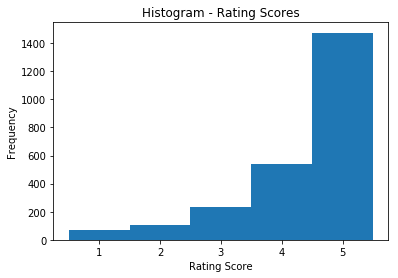

In [213]:
#Visualizations

#Histogram

plt.xlabel('Rating Score')
hotelDf['ratingScore'].plot(kind='hist', title='Histogram - Rating Scores',
                            bins=np.arange(1,7)-0.5)
plt.show()

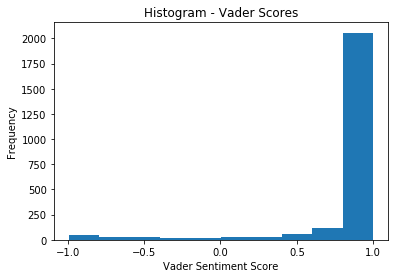

In [214]:

plt.xlabel('Vader Sentiment Score')
hotelDf['vaderScore'].plot(kind='hist', title='Histogram - Vader Scores', 
                           xticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


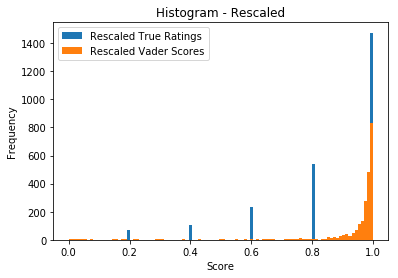

In [215]:
#Overlayed Histogram for GT rating and VD score
#Just for demonstrating, I am dividing the rating score by 5
x = [hotelDf['ratingScore'].as_matrix() / 5]
y = [(hotelDf['vaderScore'].as_matrix() + 1 )/ 2]
bins = np.linspace(0, 1, 100)
plt.hist(x, bins, label='Rescaled True Ratings')
plt.hist(y, bins, label='Rescaled Vader Scores')
plt.title('Histogram - Rescaled')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

In [216]:
#Boxplot

#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = ratingByHotel.sort_values('ratingScore', ascending=False).head(5).hotelName.as_matrix()

tempdf = hotelDf[(hotelDf.hotelName == tp5gthotel[0]) | (hotelDf.hotelName == tp5gthotel[1]) | 
         (hotelDf.hotelName == tp5gthotel[2]) | (hotelDf.hotelName == tp5gthotel[3]) | 
         (hotelDf.hotelName == tp5gthotel[4])]

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


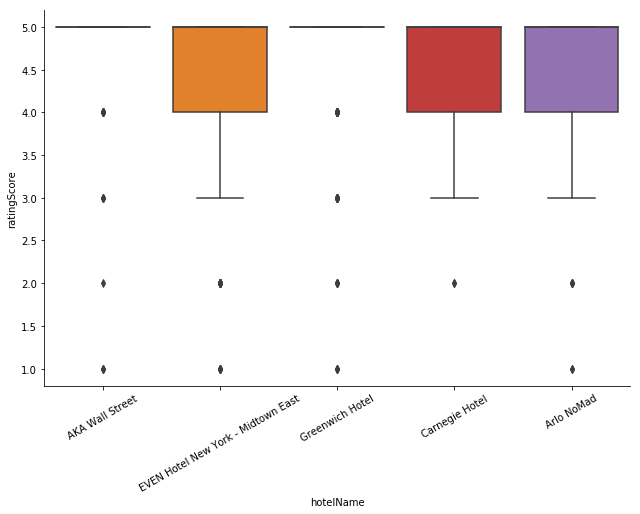

In [217]:
g = sns.factorplot(kind='box',        # Boxplot
               y='ratingScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


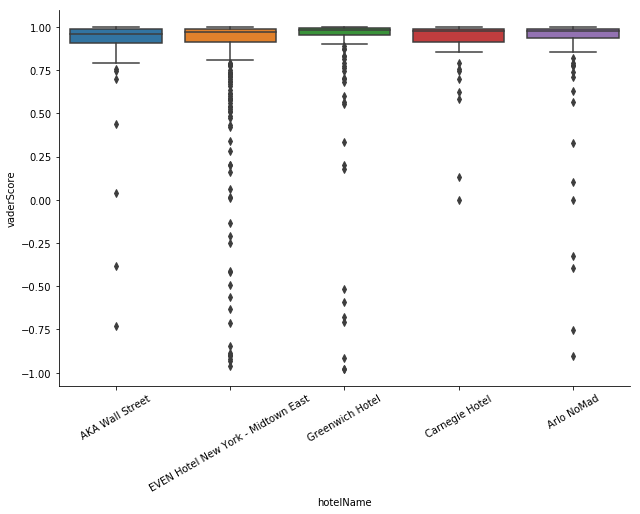

In [218]:
g = sns.factorplot(kind='box',        # Boxplot
               y='vaderScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


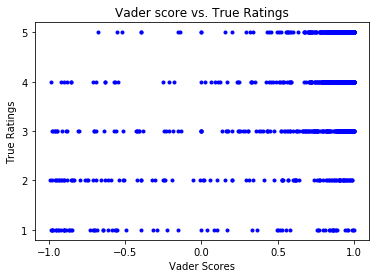

In [219]:
y = hotelDf['ratingScore'].as_matrix()
x = hotelDf['vaderScore'].as_matrix()
plt.title('Vader score vs. True Ratings')
plt.xlabel('Vader Scores')
plt.ylabel('True Ratings')
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([1,2,3,4,5])
plt.plot(x, y, "o", ms=3, color='b')
plt.show()